In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../l3.mplstyle')
import pydicom 
import os
import matplotlib as mpl
cmap = mpl.colormaps.get_cmap('tab10').colors

C:/Users/steph/Downloads/MRT/T1WEIGHTED_IMAGE_TSE_0017\902.MR.PRAKTIKUM_SCAN_PROTOCOL.0017.0015.2024.06.26.11.29.54.49682.156724705.IMA


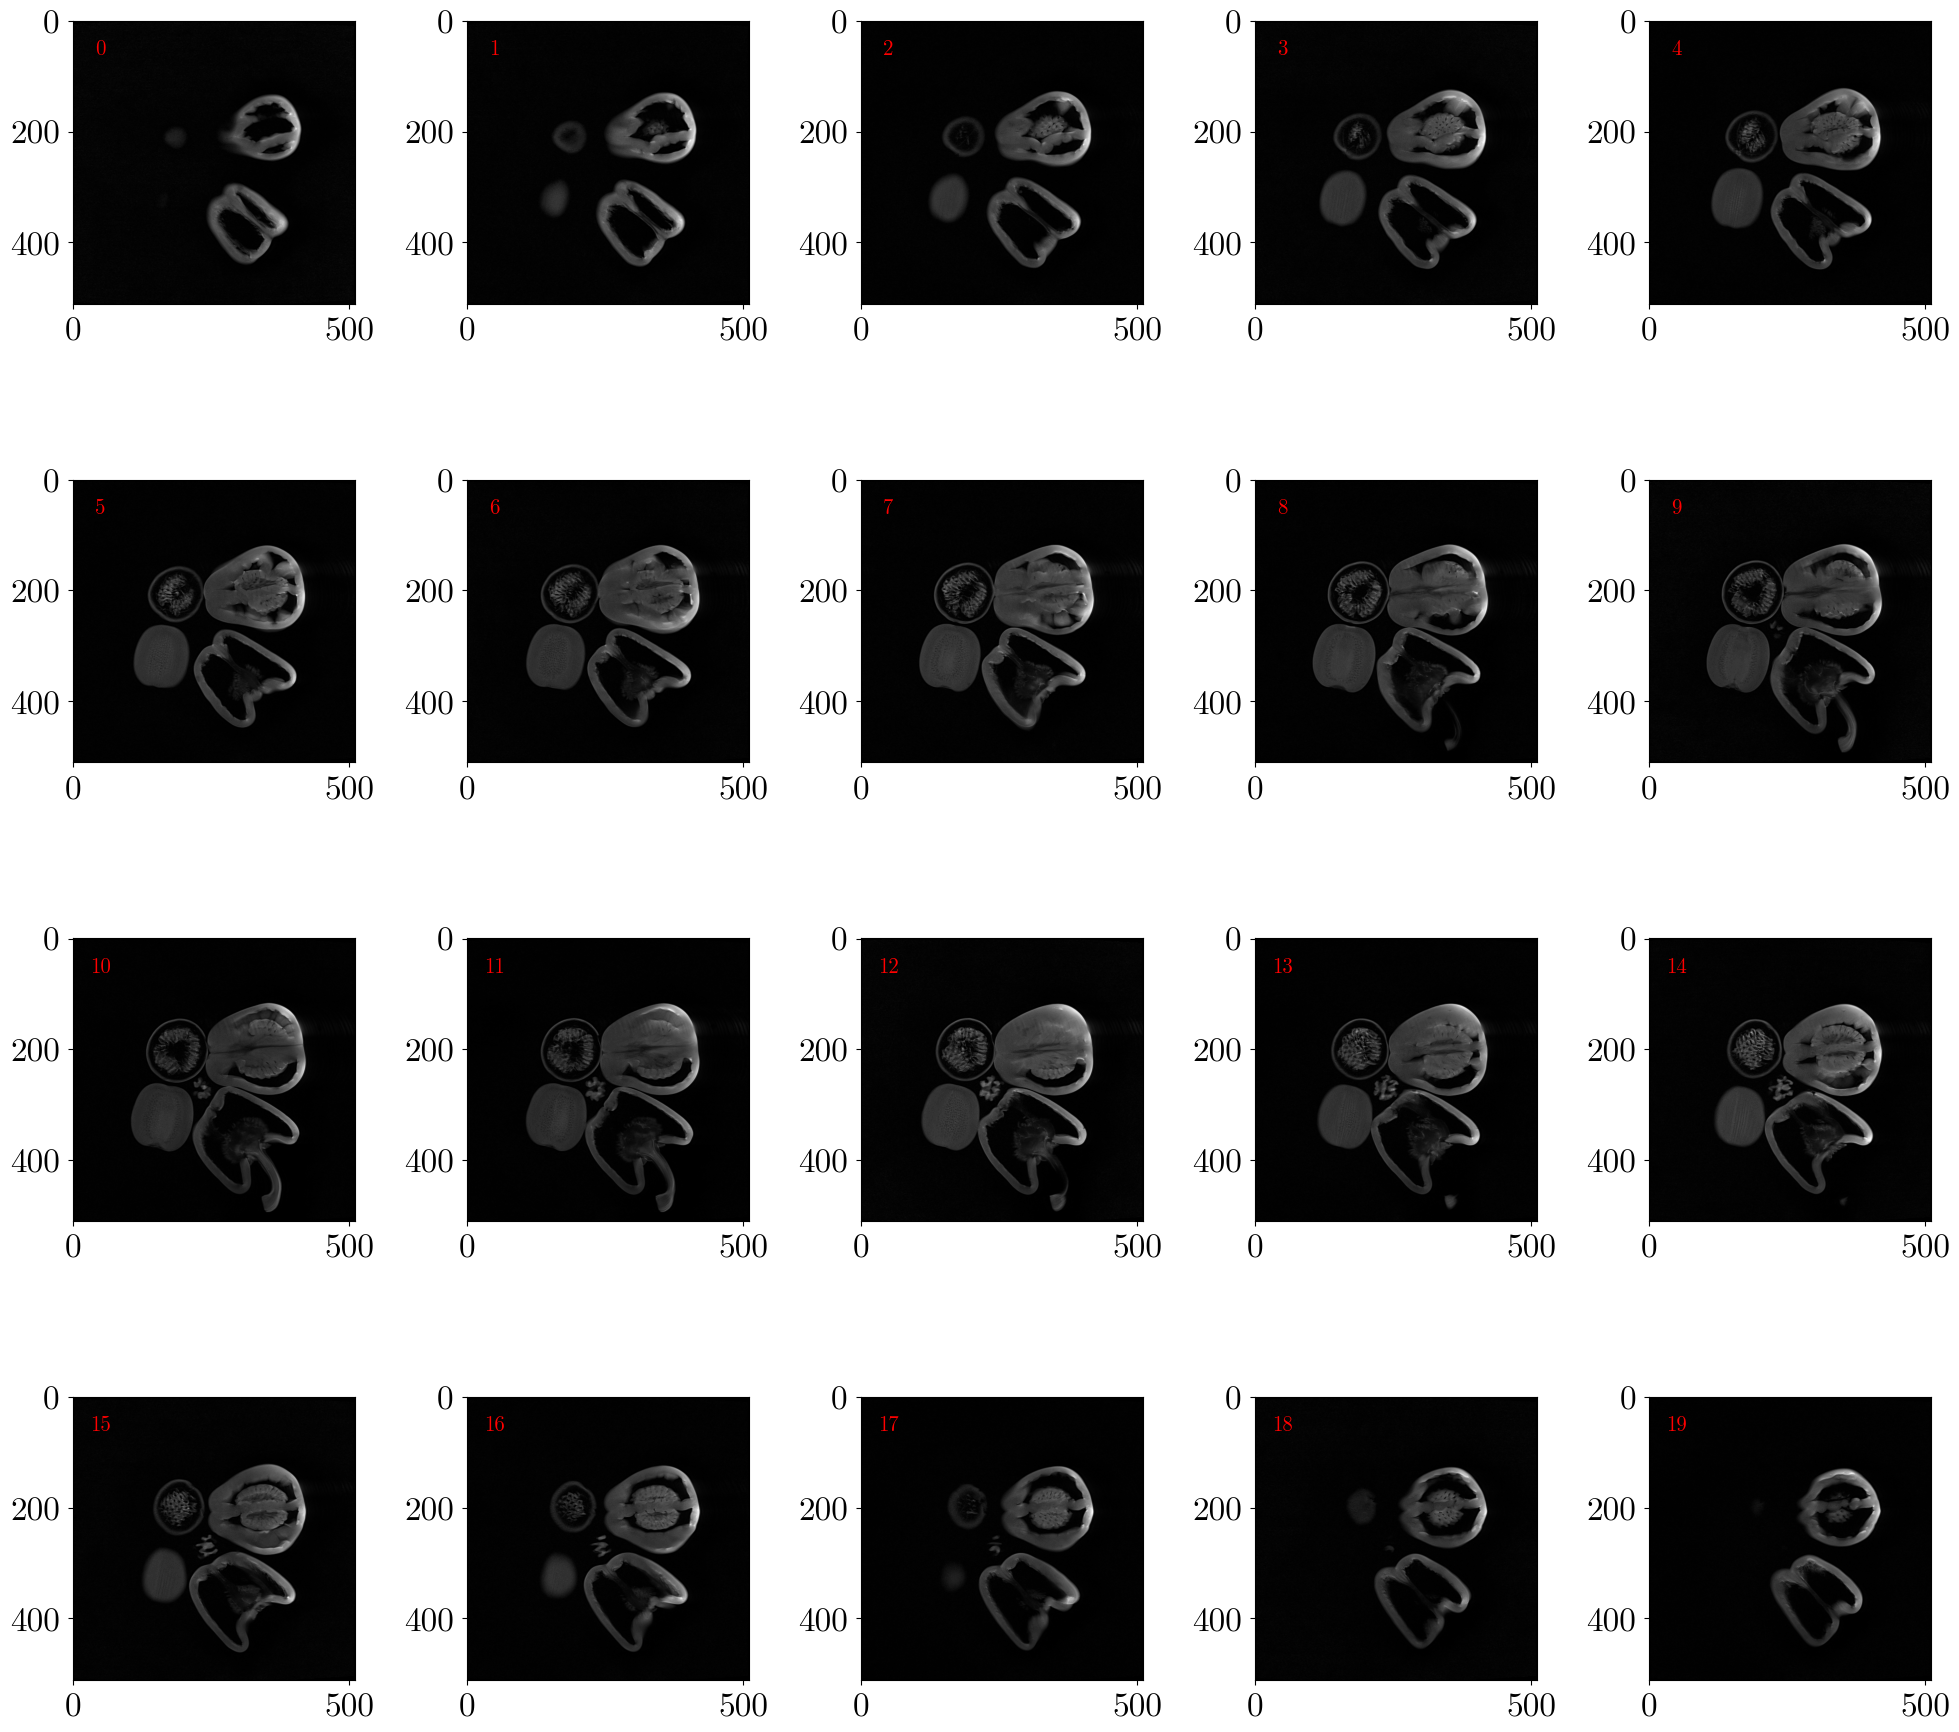

In [2]:
#path = 'C:/Users/steph/Downloads/MRT/T1WEIGHTED_IMAGE_TSE_0002'
#path = 'C:/Users/steph/Downloads/MRT/T1_WEIGHTED_LOWRES_0003'
#path = 'C:/Users/steph/Downloads/MRT/T2_WEIGTHED_0004'
#path = 'C:/Users/steph/Downloads/MRT/T1WEIGHTED_IMAGE_ARTIFACT_0005'
path = 'C:/Users/steph/Downloads/MRT/T1WEIGHTED_IMAGE_TSE_0017'
impaths = [os.path.join(path, f) for f in os.listdir(path)]
nrows, ncols = 4,5
fig,ax = plt.subplots(nrows, ncols, figsize=(20, 20))
slice = 0
for row in range(nrows):
    for column in range(ncols):  
        with pydicom.dcmread(impaths[slice]) as image:
            arr = image.pixel_array
            ax[row,column].imshow(image.pixel_array, cmap='gray')
            ax[row,column].text(50, 50, str(slice), fontsize=15, color='red', ha='center', va='center')
            slice += 1
            
print(impaths[14])

## Find ROI for last image

SNR: 52.923653903144384


webf NOT subset; don't know how to subset; dropped


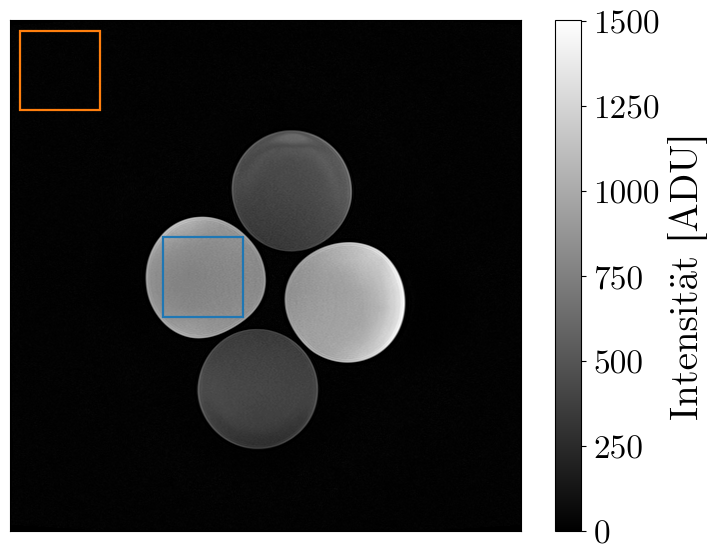

In [3]:
# High SNR image (first t1)
image = pydicom.dcmread('C:/Users/steph/Downloads/MRT/T1WEIGHTED_IMAGE_TSE_0002/902.MR.PRAKTIKUM_SCAN_PROTOCOL.0002.0011.2024.06.26.11.29.54.49682.156687664.IMA')
arr = image.pixel_array
x_on, y_on = 153, 217
x_off, y_off = 10,10
width = 80
roi_on = arr[y_on:y_on+width, x_on:x_on+width]
roi_off = arr[y_off:y_off+width, x_off:x_off+width]
vmin, vmax = image.SmallestImagePixelValue, image.LargestImagePixelValue

# Prettyfiy plot for report:
fig,ax = plt.subplots()
im = ax.imshow(arr, cmap='gray', vmin=vmin, vmax=vmax)
rect_on = plt.Rectangle((x_on,y_on),width,width, edgecolor=cmap[0], facecolor='none')
rect_off = plt.Rectangle((x_off,y_off),width,width, edgecolor=cmap[1], facecolor='none')
ax.add_patch(rect_on)
ax.add_patch(rect_off)
ax.set(xticks=[], yticks=[])
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Intensität [ADU]')
snr = np.mean(roi_on)/np.mean(roi_off)
print(f'SNR: {snr}')
fig.tight_layout()
fig.savefig('plots/t1_high_snr.pdf', bbox_inches='tight')

SNR: 16.561221722259358


webf NOT subset; don't know how to subset; dropped


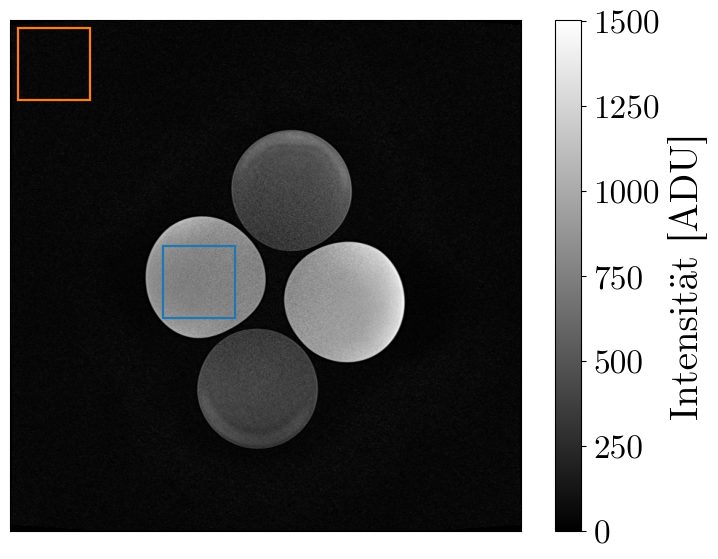

In [14]:
# low SNR image (second t1)
image = pydicom.dcmread('C:/Users/steph/Downloads/MRT/T1_WEIGHTED_LOWRES_0003/902.MR.PRAKTIKUM_SCAN_PROTOCOL.0003.0011.2024.06.26.11.29.54.49682.156689714.IMA')
arr = image.pixel_array
#print(image)
x_on, y_on = 210, 310
x_off, y_off = 10,10
width = 100
roi_on = arr[y_on:y_on+width, x_on:x_on+width]
roi_off = arr[y_off:y_off+width, x_off:x_off+width]

# Prettyfiy plot for report:
fig,ax = plt.subplots()
im = ax.imshow(arr, cmap='gray', vmin=vmin, vmax=vmax)
rect_on = plt.Rectangle((x_on,y_on),width,width, edgecolor=cmap[0], facecolor='none')
rect_off = plt.Rectangle((x_off,y_off),width,width, edgecolor=cmap[1], facecolor='none')
ax.add_patch(rect_on)
ax.add_patch(rect_off)
ax.set(xticks=[], yticks=[])
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Intensität [ADU]')
snr = np.mean(roi_on)/np.mean(roi_off)
print(f'SNR: {snr}')
fig.tight_layout()
fig.savefig('plots/t1_low_snr.pdf', bbox_inches='tight')

# Plot the other pictures needed as well
## T1 vs T2

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 178
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.12.2.1107.5.2.43.67001.2024062609130727396300914
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.12.2.1107.5.2
(0002, 0013) Implementation Version Name         SH: 'MR_VE11E'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M', 'NORM', 'DIS2D']
(0008, 0012) Instance Creation Date              DA: '20240626'
(0008, 0013) Instance Creation Time              TM: '091310.067000'
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Ins

webf NOT subset; don't know how to subset; dropped


Contrast t2: 0.26471933950066406


webf NOT subset; don't know how to subset; dropped


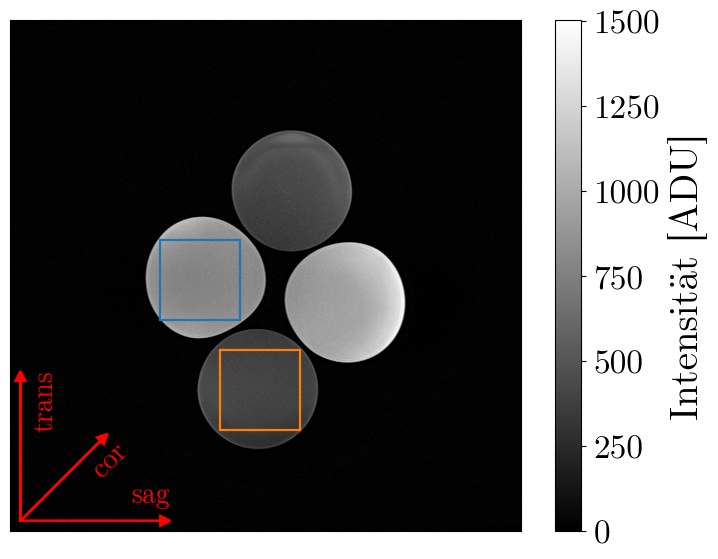

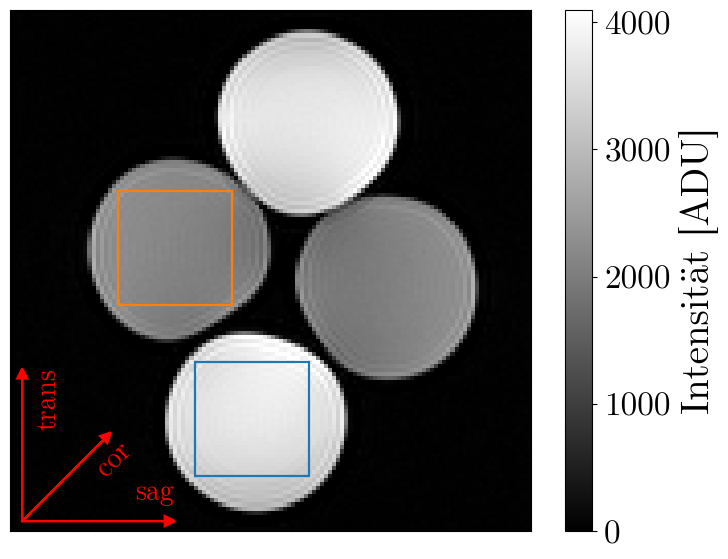

In [12]:
with pydicom.dcmread('C:/Users/steph/Downloads/MRT/T1WEIGHTED_IMAGE_TSE_0002/902.MR.PRAKTIKUM_SCAN_PROTOCOL.0002.0011.2024.06.26.11.29.54.49682.156687664.IMA') as image_t1:
    arr_t1 = image_t1.pixel_array
    vmin, vmax = image_t1.SmallestImagePixelValue, image_t1.LargestImagePixelValue
    print(image_t1)
with pydicom.dcmread('C:/Users/steph/Downloads/MRT/T2_WEIGTHED_0004\902.MR.PRAKTIKUM_SCAN_PROTOCOL.0004.0011.2024.06.26.11.29.54.49682.156691663.IMA') as image_t2:
    arr_t2 = image_t2.pixel_array
   
fig,ax = plt.subplots()
im_t1 = ax.imshow(arr_t1, cmap='gray')
ax.set(xticks=[], yticks=[])
cbar = fig.colorbar(im_t1, ax=ax)
cbar.set_label('Intensität [ADU]')
# Determine Michelson-contrast:
x_bright, y_bright = 150, 220
x_dark, y_dark = 210, 330
width = 80
roi_bright = arr_t1[y_bright:y_bright+width, x_bright:x_bright+width]
roi_dark = arr_t1[y_dark:y_dark+width, x_dark:x_dark+width]
rect_bright = plt.Rectangle((x_bright,y_bright),width,width, edgecolor=cmap[0], facecolor='none')
rect_dark = plt.Rectangle((x_dark,y_dark),width,width, edgecolor=cmap[1], facecolor='none')
ax.add_patch(rect_bright)
ax.add_patch(rect_dark)
contrast = (np.mean(roi_bright)-np.mean(roi_dark))/(np.mean(roi_bright)+np.mean(roi_dark))
print(f'Contrast t1: {contrast}')
# coordinate system
ax.arrow(10,501, 80,-80, color='red', head_width=10, head_length=10)
ax.text(100, 440, 'cor', color='red', ha='center', va='center', rotation=45)
ax.arrow(10,501, 0,-140, color='red', head_width=10, head_length=10)
ax.text(35, 380, 'trans', color='red', ha='center', va='center', rotation=90)
ax.arrow(10,501, 140,0, color='red', head_width=10, head_length=10)
ax.text(140, 475, 'sag', color='red', ha='center', va='center')
fig.tight_layout()
fig.savefig('plots/t1.pdf', bbox_inches='tight')

fig,ax = plt.subplots()
im_t1 = ax.imshow(arr_t2, cmap='gray')
#ax.set(xticks=[], yticks=[])
cbar = fig.colorbar(im_t1, ax=ax)
cbar.set_label('Intensität [ADU]')
# Determine Michelson-contrast:
x_bright, y_bright = 45,86
x_dark, y_dark = 26,44
width = 28
roi_bright = arr_t2[y_bright:y_bright+width, x_bright:x_bright+width]
roi_dark = arr_t2[y_dark:y_dark+width, x_dark:x_dark+width]
rect_bright = plt.Rectangle((x_bright,y_bright),width,width, edgecolor=cmap[0], facecolor='none')
rect_dark = plt.Rectangle((x_dark,y_dark),width,width, edgecolor=cmap[1], facecolor='none')

ax.add_patch(rect_bright)
ax.add_patch(rect_dark)
ax.set(xticks=[], yticks=[])
contrast = (np.mean(roi_bright)-np.mean(roi_dark))/(np.mean(roi_bright)+np.mean(roi_dark))
print(f'Contrast t2: {contrast}')
# coordinate system
ax.arrow(2.5,125, 20,-20, color='red', head_width=2.5, head_length=2.5)
ax.text(25, 110, 'cor', color='red', ha='center', va='center', rotation=45)
ax.arrow(2.5,125, 0,-35, color='red', head_width=2.5, head_length=2.5)
ax.text(9, 95, 'trans', color='red', ha='center', va='center', rotation=90)
ax.arrow(2.5,125, 35,0, color='red', head_width=2.5, head_length=2.5)
ax.text(35, 118, 'sag', color='red', ha='center', va='center')
fig.tight_layout()
fig.savefig('plots/t2.pdf', bbox_inches='tight')

## Artefacts

webf NOT subset; don't know how to subset; dropped


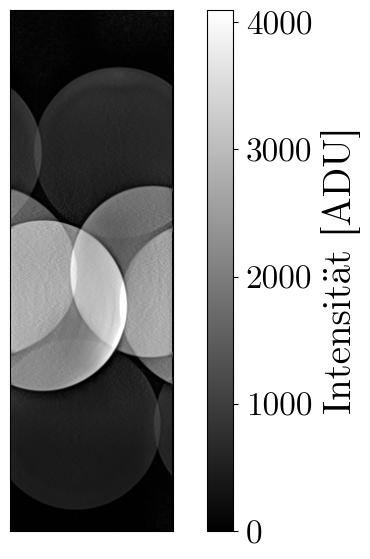

In [6]:
with pydicom.dcmread('C:/Users/steph/Downloads/MRT/T1WEIGHTED_IMAGE_ARTIFACT_0005\902.MR.PRAKTIKUM_SCAN_PROTOCOL.0005.0008.2024.06.26.11.29.54.49682.156693796.IMA') as image:
    arr = image.pixel_array
fig,ax = plt.subplots()
im = ax.imshow(arr, cmap='gray')
ax.set(xticks=[], yticks=[])
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Intensität [ADU]')
fig.tight_layout()
fig.savefig('plots/artifact.pdf', bbox_inches='tight')

## Vegetables

webf NOT subset; don't know how to subset; dropped


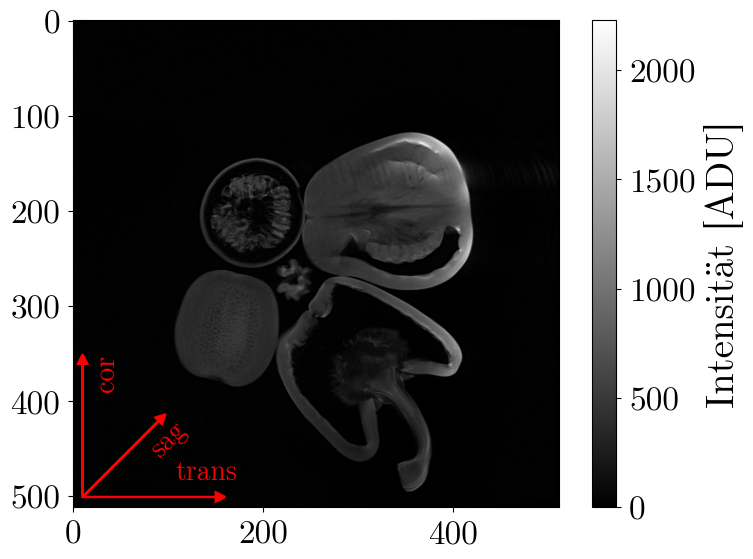

In [24]:
# with pydicom.dcmread('C:/Users/steph/Downloads/MRT/T1WEIGHTED_IMAGE_TSE_0017\902.MR.PRAKTIKUM_SCAN_PROTOCOL.0017.0015.2024.06.26.11.29.54.49682.156724705.IMA') as image:
#     arr = image.pixel_array
# fig,ax = plt.subplots(figsize=(15,10))
# im = ax.imshow(arr, cmap='gray')
# ax.set(xticks=[], yticks=[])
# cbar = fig.colorbar(im, ax=ax)
# cbar.set_label('Intensität [ADU]')
with pydicom.dcmread('C:/Users/steph/Downloads/MRT/T1WEIGHTED_IMAGE_TSE_0017/902.MR.PRAKTIKUM_SCAN_PROTOCOL.0017.0012.2024.06.26.11.29.54.49682.156724687.IMA') as image:
    arr = image.pixel_array
    #print(image)
fig,ax = plt.subplots()
im = ax.imshow(arr, cmap='gray')
#ax.set(xticks=[], yticks=[])
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Intensität [ADU]')
# Coordinate system
ax.arrow(10,501, 80,-80, color='red', head_width=10, head_length=10)
ax.text(100, 440, 'sag', color='red', ha='center', va='center', rotation=45)
ax.arrow(10,501, 0,-140, color='red', head_width=10, head_length=10)
ax.text(35, 370, 'cor', color='red', ha='center', va='center', rotation=90)
ax.arrow(10,501, 140,0, color='red', head_width=10, head_length=10)
ax.text(140, 475, 'trans', color='red', ha='center', va='center')
fig.tight_layout()
fig.savefig('plots/veggie.pdf', bbox_inches='tight')